Training set shape: (1812, 51)
Test set shape: (453, 45)
'W' column in train dataset: True
'W' column in test dataset: False
Number of available default features: 44
Training set shape: (1449, 44)
Validation set shape: (363, 44)
Final test set shape: (453, 44)

Linear Regression Performance:
  Training MAE: 2.6625
  Validation MAE: 2.8925
  Validation RMSE: 3.6456
  Validation R²: 0.9172

Top 10 Most Important Features:
        Feature  Coefficient
1             R     8.813970
16       IPouts     6.249489
2            AB    -6.225434
10           RA    -6.012029
15           SV     4.098789
13           CG     3.303077
11           ER    -3.282859
3             H     3.253957
12          ERA     3.086878
34  decade_1920    -2.916170


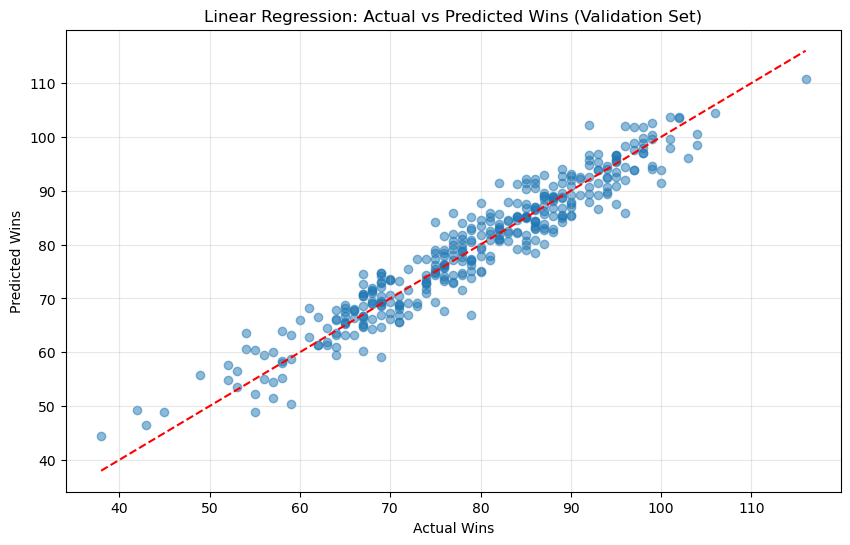

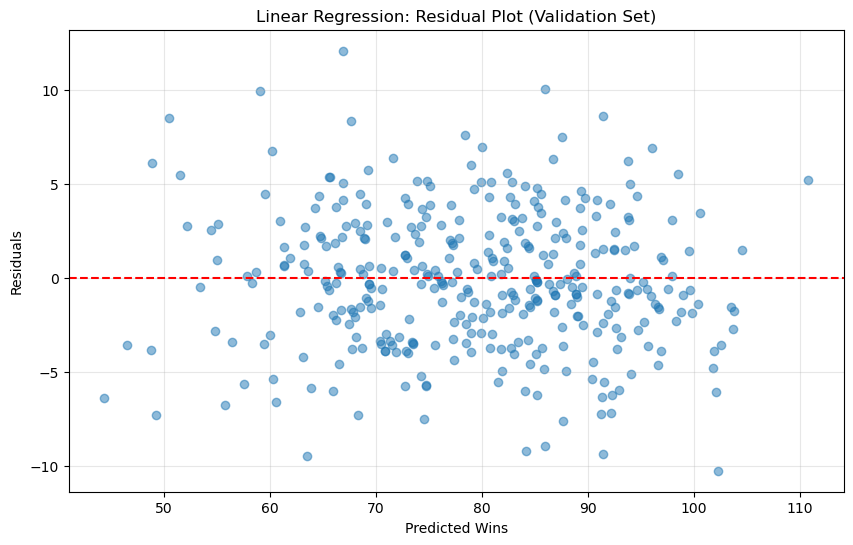


Generated 453 predictions for the test set
Prediction range: 44.46 to 108.42

Submission dataframe shape: (453, 2)
First few predictions:
     ID          W
0  1756  70.406736
1  1282  74.837327
2   351  83.615544
3   421  87.104174
4    57  93.888728


In [2]:
## Starter Code for Building Baseball Win Prediction Model

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pathlib import Path


# Build robust path to data folder (notebooks and data are siblings)
DATA_DIR = Path.cwd().parent / 'data'
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'


# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)  # This is for final predictions (no 'W' column)


# Display basic information about the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"'W' column in train dataset: {'W' in train_df.columns}")
print(f"'W' column in test dataset: {'W' in test_df.columns}")


# Select only the default features from DATA_DESCRIPTION.md
default_features = [
    # Basic Statistics
    'G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
    'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
    'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
    
    # Derived Features
    'R_per_game', 'RA_per_game', 'mlb_rpg',
    
    # Era Indicators
    'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
    # Decade Indicators
    'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
 ]


# Filter features that exist in both training data AND test data
available_features = [col for col in default_features 
                     if col in train_df.columns and col in test_df.columns]
print(f"Number of available default features: {len(available_features)}")


# Prepare training data (split the train.csv for model evaluation)
X_full = train_df[available_features]
y_full = train_df['W']

# Split training data into train/validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Prepare final test data for predictions (this has no target variable)
X_test_final = test_df[available_features]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Final test set shape: {X_test_final.shape}")


# Scale features
# Identify columns to exclude from scaling (one-hot encoded and label columns)
one_hot_cols = [col for col in X_train.columns if col.startswith(('era_', 'decade_'))]
other_cols = [col for col in X_train.columns if col not in one_hot_cols]


# Scale only non-one-hot features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_final_scaled = X_test_final.copy()

X_train_scaled[other_cols] = scaler.fit_transform(X_train[other_cols])
X_val_scaled[other_cols] = scaler.transform(X_val[other_cols])
X_test_final_scaled[other_cols] = scaler.transform(X_test_final[other_cols])


# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_train_preds = lr.predict(X_train_scaled)
lr_val_preds = lr.predict(X_val_scaled)
lr_test_final_preds = lr.predict(X_test_final_scaled)


# Evaluate Linear Regression (using validation set)
lr_train_mae = mean_absolute_error(y_train, lr_train_preds)
lr_val_mae = mean_absolute_error(y_val, lr_val_preds)
lr_val_rmse = np.sqrt(mean_squared_error(y_val, lr_val_preds))
lr_val_r2 = r2_score(y_val, lr_val_preds)


print(f"\nLinear Regression Performance:")
print(f"  Training MAE: {lr_train_mae:.4f}")
print(f"  Validation MAE: {lr_val_mae:.4f}")
print(f"  Validation RMSE: {lr_val_rmse:.4f}")
print(f"  Validation R²: {lr_val_r2:.4f}")


# Feature importance from Linear Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)


print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


# Visualize actual vs predicted values (using validation set)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, lr_val_preds, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Linear Regression: Actual vs Predicted Wins (Validation Set)')
plt.grid(True, alpha=0.3)
plt.show()


# Add residual plot (using validation set)
plt.figure(figsize=(10, 6))
residuals = y_val - lr_val_preds
plt.scatter(lr_val_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot (Validation Set)')
plt.grid(True, alpha=0.3)
plt.show()


# Generate predictions for the final test set (for submission)
print(f"\nGenerated {len(lr_test_final_preds)} predictions for the test set")
print(f"Prediction range: {lr_test_final_preds.min():.2f} to {lr_test_final_preds.max():.2f}")

# Create submission dataframe
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'W': lr_test_final_preds
})

print(f"\nSubmission dataframe shape: {submission_df.shape}")
print("First few predictions:")
print(submission_df.head())